In [1]:
import zipfile, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import imageio
from PIL import Image
from IPython.display import HTML, display
import folium
from folium.plugins import HeatMap

#Uploading of Dataset

In [2]:
uploaded = files.upload()
pauri_zip = list(uploaded.keys())[0]
uttarkashi_zip = list(uploaded.keys())[1]

Saving Pauri_Garhwal.zip to Pauri_Garhwal (3).zip
Saving Uttarkashi (1).zip to Uttarkashi (1) (3).zip


In [3]:
pauri_path = '/content/pauri_data'
uttarkashi_path = '/content/uttarkashi_data'
os.makedirs(pauri_path, exist_ok=True)
os.makedirs(uttarkashi_path, exist_ok=True)

with zipfile.ZipFile(pauri_zip, 'r') as zip_ref:
    zip_ref.extractall(pauri_path)
with zipfile.ZipFile(uttarkashi_zip, 'r') as zip_ref:
    zip_ref.extractall(uttarkashi_path)

In [4]:
def load_folder(path):
    data = {}
    for file in os.listdir(path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, file))
            print(f"\nLoaded {file} with shape: {df.shape}")
            print(df.describe(include='all').T.head())
            data[file] = df
    return data

pauri_data = load_folder(pauri_path)
uttarkashi_data = load_folder(uttarkashi_path)


Loaded reanalysis-era5-land-timeseries-sfc-soil-waterdzibwrvr.csv with shape: (87672, 5)
              count unique                  top freq      mean       std  \
valid_time    87672  87672  2024-12-31 23:00:00    1       NaN       NaN   
swvl1       87672.0    NaN                  NaN  NaN  0.387229  0.084222   
swvl2       87672.0    NaN                  NaN  NaN  0.395089  0.070746   
latitude    87672.0    NaN                  NaN  NaN      30.1       0.0   
longitude   87672.0    NaN                  NaN  NaN      78.8       0.0   

                 min       25%       50%       75%       max  
valid_time       NaN       NaN       NaN       NaN       NaN  
swvl1       0.231461  0.309051  0.401367  0.465652  0.520004  
swvl2       0.279709  0.327255  0.392654  0.466553  0.520004  
latitude        30.1      30.1      30.1      30.1      30.1  
longitude       78.8      78.8      78.8      78.8      78.8  

Loaded reanalysis-era5-land-timeseries-sfc-windd211vwhm.csv with shape: (8

#Preprocessing

In [5]:
def preprocess(df):
    print("\nBefore preprocessing:")
    print(df.isnull().sum())
    df = df.fillna(df.mean(numeric_only=True))
    df['valid_time'] = pd.date_range(start='2023-01-01', periods=len(df), freq='h')
    scaler = MinMaxScaler()
    df[df.select_dtypes(include=np.number).columns] = scaler.fit_transform(df.select_dtypes(include=np.number))
    df = df.set_index('valid_time').resample('D').mean()
    print("After preprocessing:")
    print(df.head())
    return df

for k in pauri_data:
    pauri_data[k] = preprocess(pauri_data[k])


Before preprocessing:
valid_time    0
swvl1         0
swvl2         0
latitude      0
longitude     0
dtype: int64
After preprocessing:
               swvl1     swvl2  latitude  longitude
valid_time                                         
2023-01-01  0.484801  0.475534       0.0        0.0
2023-01-02  0.820723  0.634604       0.0        0.0
2023-01-03  0.858126  0.884808       0.0        0.0
2023-01-04  0.867284  0.828200       0.0        0.0
2023-01-05  0.815803  0.792098       0.0        0.0

Before preprocessing:
valid_time    0
u10           0
v10           0
latitude      0
longitude     0
dtype: int64
After preprocessing:
                 u10       v10  latitude  longitude
valid_time                                         
2023-01-01  0.385048  0.553453       0.0        0.0
2023-01-02  0.314829  0.473798       0.0        0.0
2023-01-03  0.317826  0.502904       0.0        0.0
2023-01-04  0.406598  0.546980       0.0        0.0
2023-01-05  0.393291  0.575754       0.0        0.

#Data Visualization

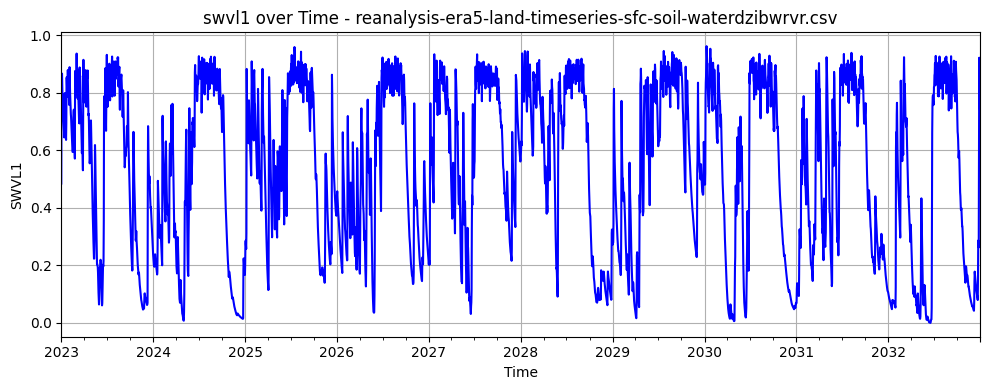

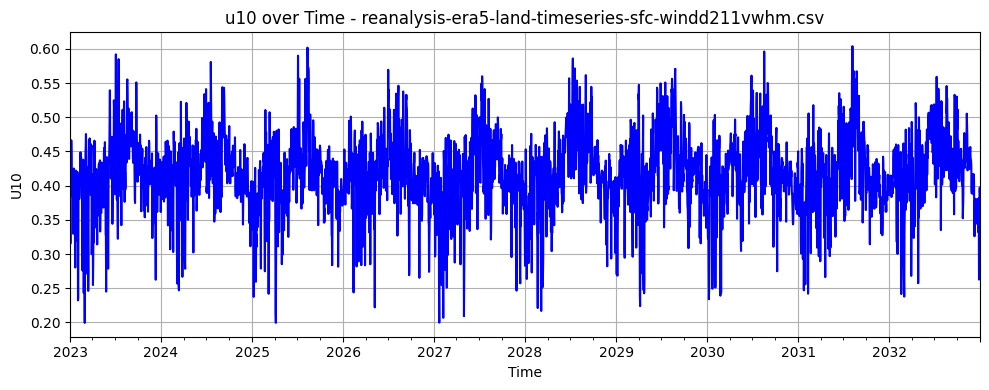

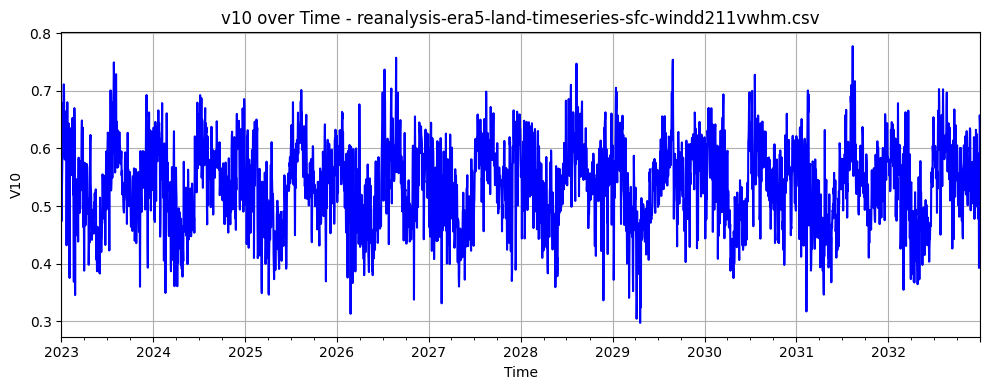

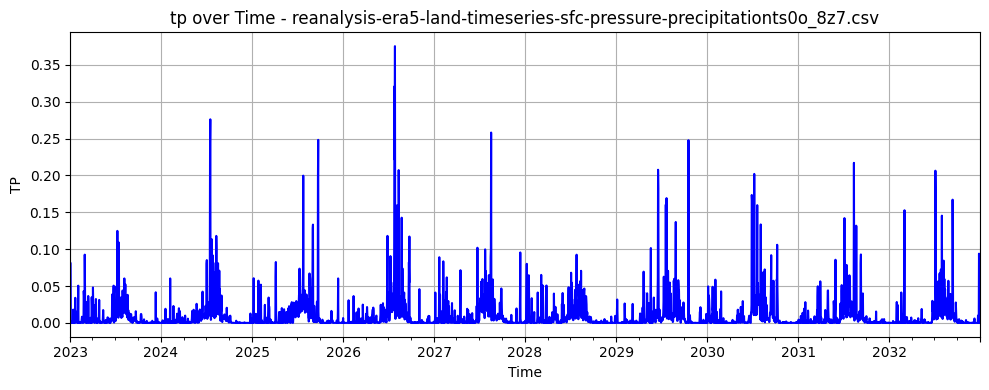

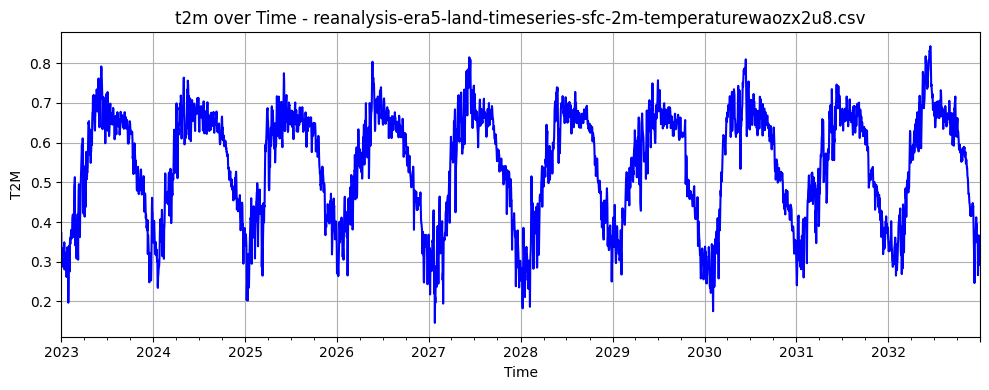

In [6]:
def plot_timeseries(df, column, title, ylabel, color):
    if column in df.columns:
        plt.figure(figsize=(10, 4))
        df[column].plot(color=color)
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

for name, df in pauri_data.items():
    for col in ['t2m', 'u10', 'v10', 'swvl1', 'tp']:
        if col in df.columns:
            plot_timeseries(df, col, f"{col} over Time - {name}", col.upper(), 'blue')


#Feature Engineering

In [7]:
merged_df = pd.DataFrame(index=next(iter(pauri_data.values())).index)
for key, df in pauri_data.items():
    merged_df = merged_df.join(df, how='outer', rsuffix=f'_{key}')

merged_df = merged_df.ffill().bfill()

merged_df['wind_speed'] = np.sqrt(merged_df.filter(like='u10').mean(axis=1)**2 + merged_df.filter(like='v10').mean(axis=1)**2)

mean_temp = merged_df.filter(like='t2m').mean(axis=1)
mean_soil = merged_df.filter(like='swvl1').mean(axis=1)

merged_df['fire_risk_score'] = (
    0.4 * mean_temp +
    0.4 * merged_df['wind_speed'] -
    0.3 * mean_soil
)
merged_df['fire_risk_score'] = MinMaxScaler().fit_transform(merged_df[['fire_risk_score']])


#Modelling

In [8]:
X = merged_df.drop(columns=['fire_risk_score'])
y = merged_df['fire_risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

MSE: 0.0001


#Predicting Next 6 Hours

In [9]:
latitude_min, latitude_max = 30.1, 30.6
longitude_min, longitude_max = 78.5, 79.0
n_grid = 10
future_frames = 6
last_known = X_test.iloc[-(n_grid * n_grid):].copy()
future_images = []

latitudes = np.linspace(latitude_min, latitude_max, n_grid)
longitudes = np.linspace(longitude_min, longitude_max, n_grid)

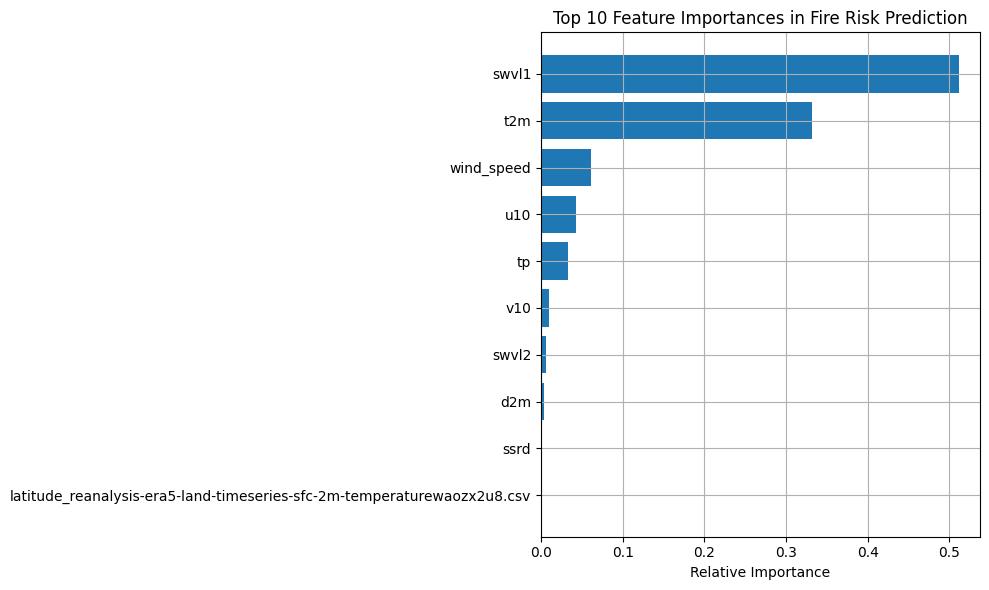

In [13]:
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:][::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 10 Feature Importances in Fire Risk Prediction')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


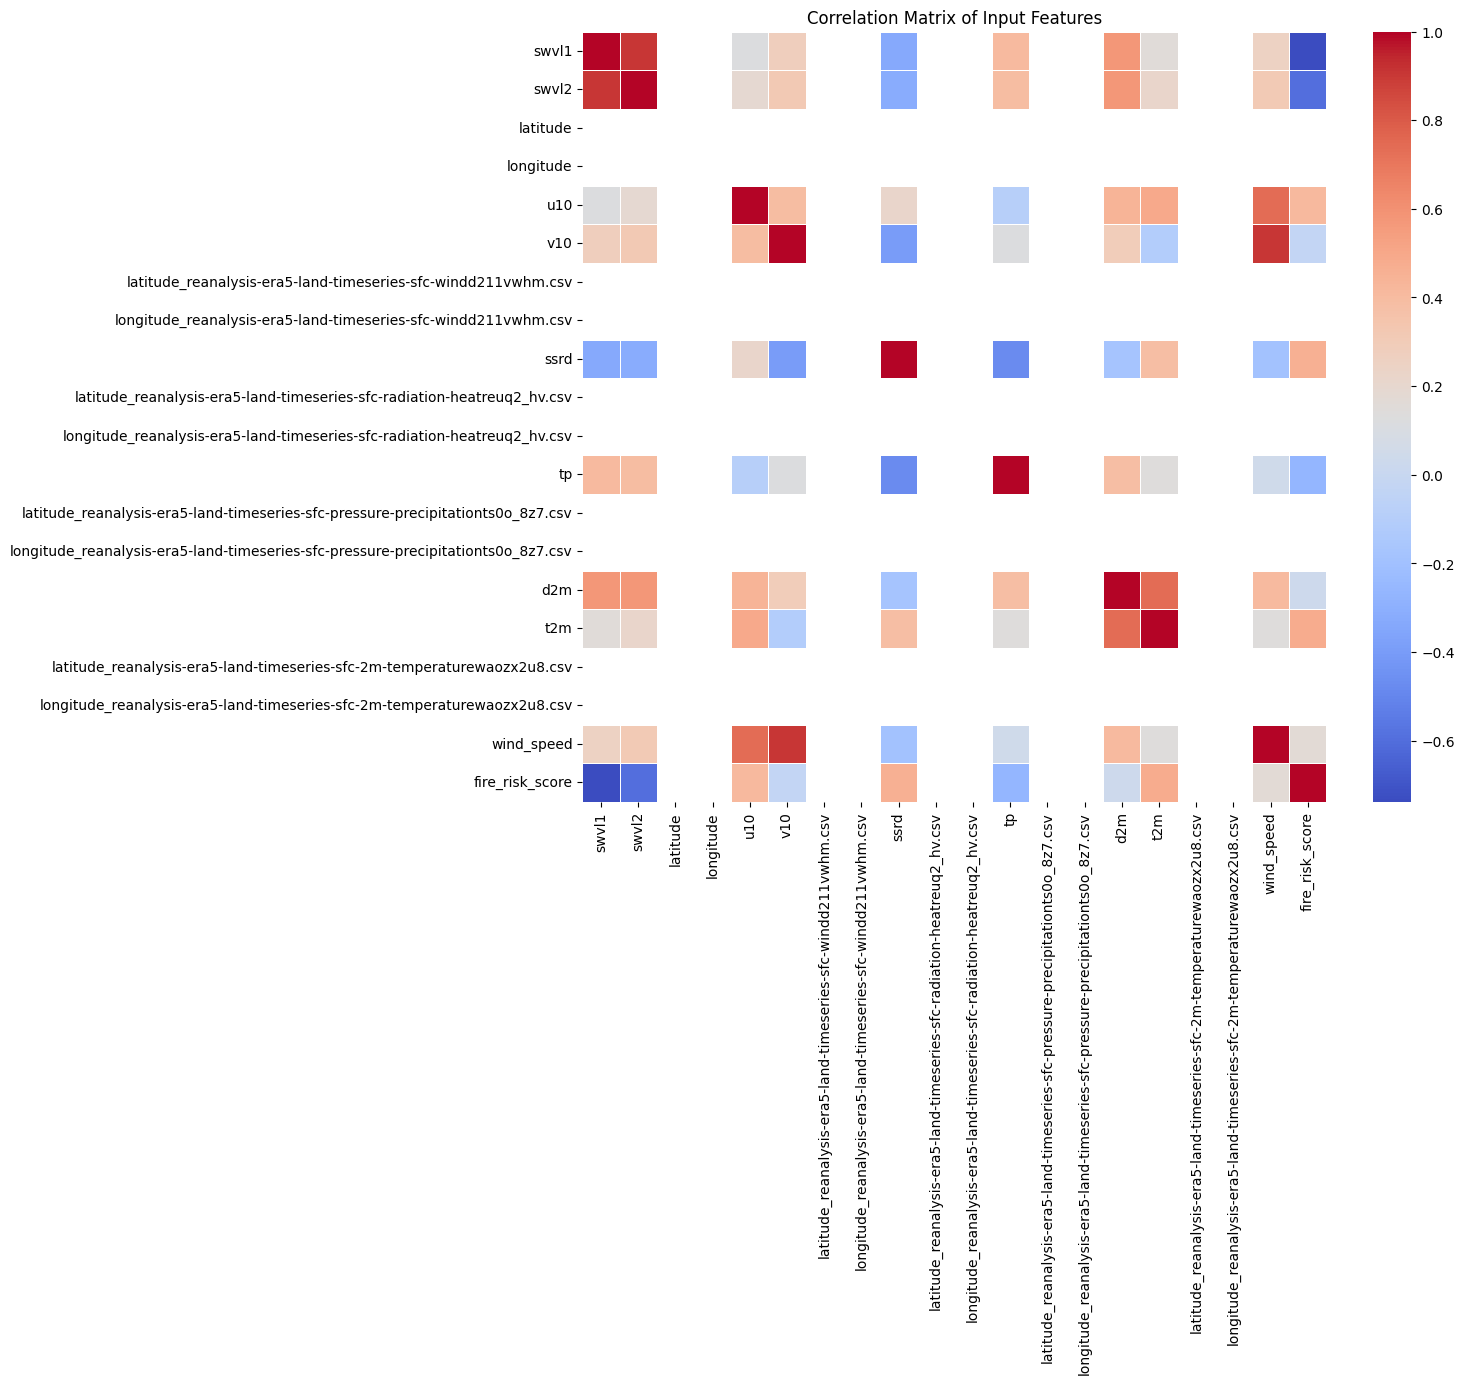

In [16]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(merged_df.corr(), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Correlation Matrix of Input Features')
plt.show()


/tmp/ipython-input-46-1146708841.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  future_images.append(imageio.imread(filename))
/tmp/ipython-input-46-1146708841.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  future_images.append(imageio.imread(filename))
/tmp/ipython-input-46-1146708841.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  future_images.append(imageio.imre


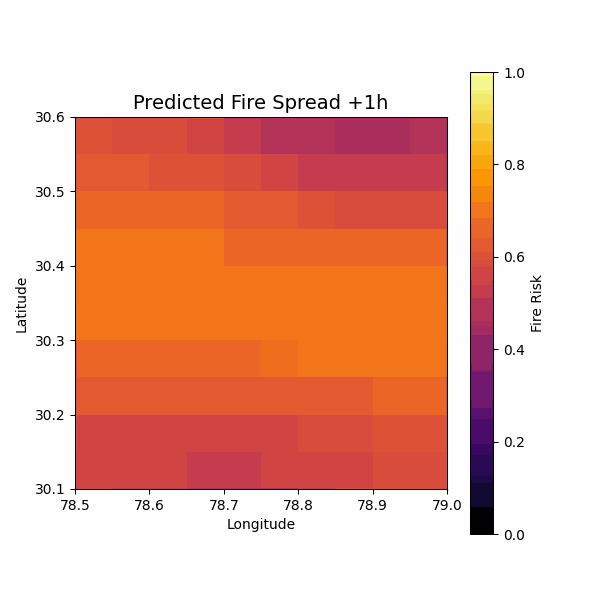

In [46]:
from scipy.ndimage import gaussian_filter
import base64
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import imageio

latitude_min, latitude_max = 30.1, 30.6
longitude_min, longitude_max = 78.5, 79.0
n_grid = 10
future_frames = 12
frame_duration = 2.5


last_known = X_test.iloc[-(n_grid * n_grid):].copy()
future_images = []
previous_frame = None

latitudes = np.linspace(latitude_min, latitude_max, n_grid)
longitudes = np.linspace(longitude_min, longitude_max, n_grid)


for t in range(future_frames):
    y_future_pred = model.predict(last_known)
    smoothed = gaussian_filter(y_future_pred.reshape(n_grid, n_grid), sigma=1.5)


    if previous_frame is not None:
        smoothed = 0.6 * smoothed + 0.4 * previous_frame
    previous_frame = smoothed.copy()


    plt.figure(figsize=(6, 6))
    plt.imshow(
        smoothed, cmap='inferno',
        extent=[longitude_min, longitude_max, latitude_min, latitude_max],
        origin='lower', vmin=0.0, vmax=1.0
    )
    plt.title(f"Predicted Fire Spread +{(t+1)}h", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Fire Risk")
    filename = f"spread_frame_{t}.png"
    plt.savefig(filename)
    plt.close()

    future_images.append(imageio.imread(filename))


    if 't2m' in last_known.columns:
        last_known['t2m'] = 0.7 * last_known['t2m'] + 0.3 * smoothed.flatten()
    if 'swvl1' in last_known.columns:
        last_known['swvl1'] *= 0.96
    last_known *= np.random.normal(0.995, 0.01, last_known.shape)


gif_path = "realistic_fire_spread.gif"
imageio.mimsave(gif_path, future_images, duration=frame_duration)

with open(gif_path, "rb") as f:
    data_uri = base64.b64encode(f.read()).decode("utf-8")
display(HTML(f'<img src="data:image/gif;base64,{data_uri}" width="700">'))


In [23]:
!pip install contextily geopandas pyproj shapely


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.1 MB/s eta 0:00:00


In [26]:
!ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)


/bin/bash: -c: line 1: syntax error near unexpected token `ax,'
/bin/bash: -c: line 1: `ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)'


/tmp/ipython-input-45-4229610940.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))
/tmp/ipython-input-45-4229610940.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))
/tmp/ipython-input-45-4229610940.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))
/tmp/ip


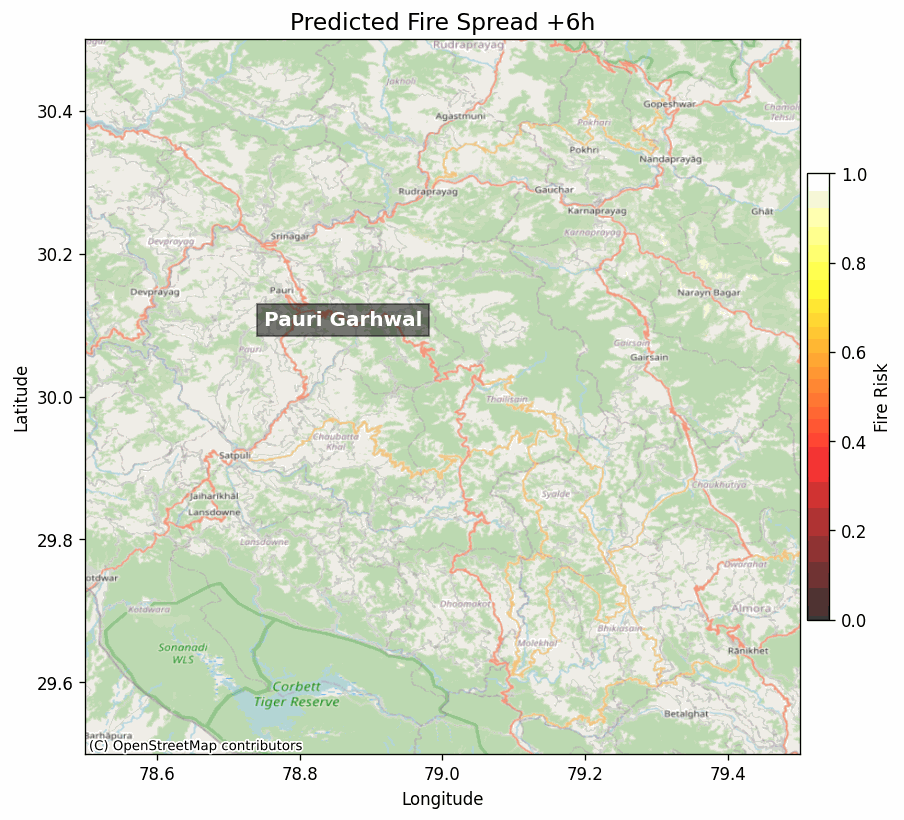

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box
from scipy.ndimage import gaussian_filter
import imageio
import base64
from IPython.display import HTML
import os


longitude_min, longitude_max = 78.5, 79.5
latitude_min, latitude_max = 29.5, 30.5
n_grid = 10
time_steps = [6, 8, 12, 24]
frames = []

bbox = box(longitude_min, latitude_min, longitude_max, latitude_max)
gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs="EPSG:4326")


lons = np.linspace(longitude_min, longitude_max, n_grid)
lats = np.linspace(latitude_min, latitude_max, n_grid)
xx, yy = np.meshgrid(lons, lats)

np.random.seed(42)
base = np.random.uniform(0.3, 0.6, size=(n_grid, n_grid))


for step, hour in enumerate(time_steps):
    fire_spread = gaussian_filter(base, sigma=1.2 + step * 0.3)
    fire_spread += 0.03 * step
    fire_spread = np.clip(fire_spread, 0, 1)

    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, edgecolor='none', alpha=0)

    heatmap = ax.imshow(
        fire_spread,
        cmap='hot',
        extent=[longitude_min, longitude_max, latitude_min, latitude_max],
        origin='lower',
        vmin=0, vmax=1,
        alpha=0.8
    )


    terrain = ctx.providers.OpenStreetMap.Mapnik
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=terrain, zoom=10)


    ax.text(78.75, 30.1, "Pauri Garhwal", fontsize=12, color="white", weight="bold", bbox=dict(facecolor='black', alpha=0.5))


    ax.set_title(f"Predicted Fire Spread +{hour}h", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(longitude_min, longitude_max)
    ax.set_ylim(latitude_min, latitude_max)
    cbar = plt.colorbar(heatmap, ax=ax, fraction=0.03, pad=0.01)
    cbar.set_label("Fire Risk")


    filename = f"/tmp/map_frame_{hour}h.png"
    plt.savefig(filename, dpi=120, bbox_inches='tight')
    plt.close()

    frames.append(imageio.imread(filename))


gif_path = "final_fire_spread.gif"
imageio.mimsave(gif_path, frames, duration=2.5)


with open(gif_path, "rb") as f:
    data_uri = base64.b64encode(f.read()).decode("utf-8")
HTML(f'<img src="data:image/gif;base64,{data_uri}" width="720">')